# 05_A_Software_Comparison_PointCloud

In diesem Jupyter Notebook werden die Punkwolken der Softwareprodukte "Agisoft Metashape" und "Drone2Map" miteinander verglichen. 
Die Daten basieren auf Bilder der DJI Mini 3 Pro von den folgenden Aufnahmetagen:
11.03.2025 

### Import der Libraries

In [1]:
import pandas as pd
import os
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import laspy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.ticker import FuncFormatter

### Definition der Grundlagedaten

In [10]:
# CSV-Verzeichnis
csv_dir = "C:\\_Data\\BTh11\\BTh11_Trieblaengenwachstum\\03_TPF_Statistics\\30_BaseData\\CSV"
print("Daten in CSV-Verzeichnis:", os.listdir(csv_dir))

# PointCloud-Verzeichnis auf HDD
pc_hdd_dir = "F:\\530_PointClouds_TPF"
print("Daten in PointCloud-Verzeichnis (HDD):", os.listdir(pc_hdd_dir))

# PointCloud-Verzeichnis 
pc_dir = r"C:\_Data\BTh11\BTh11_Trieblaengenwachstum\05_Software_Comparison\50_BaseData\PointCloud\20250326"
print("Daten in PointCloud-Verzeichnis:", os.listdir(pc_dir))


Daten in CSV-Verzeichnis: ['MetashapeReportData_20250311_DJIMini3Pro_Kirsche.csv', 'MetashapeReportData_20250319_DJIMini3Pro_Kirsche.csv', 'MetashapeReportData_20250326_DJIMini3Pro_Kirsche.csv', 'old']
Daten in PointCloud-Verzeichnis (HDD): ['20250311_DJIMini3Pro_Kirsche_TiePointFiltering_100_clipped.las', '20250311_DJIMini3Pro_Kirsche_TiePointFiltering_20_clipped.las', '20250311_DJIMini3Pro_Kirsche_TiePointFiltering_40_clipped.las', '20250311_DJIMini3Pro_Kirsche_TiePointFiltering_60_clipped.las', '20250311_DJIMini3Pro_Kirsche_TiePointFiltering_80_clipped.las', '20250311_DJIMini3Pro_Kirsche_TiePointFiltering_90_clipped.las']
Daten in PointCloud-Verzeichnis: ['20250326_DJIMini3Pro_Kirsche_Drone2Map_clipped.las', '20250326_DJIMini3Pro_Kirsche_Metashape_clipped.las']


## 1. Punktwolkenschnitte

### 1.1 Definition der Baumdimensionen

In [11]:

tree_coord = (2615390.3, 1264898.6)
tree_null = 279.675
cut_height = tree_null + 5
step_height = 1

### 1.2 Punktwolke laden + visualisieren

In [12]:
# === Alle LAS-Dateien im Verzeichnis laden ===
las_files = [f for f in os.listdir(pc_dir) if f.endswith(".las")]
print(f"geladene LAS-Dateien: {las_files}")

geladene LAS-Dateien: ['20250326_DJIMini3Pro_Kirsche_Drone2Map_clipped.las', '20250326_DJIMini3Pro_Kirsche_Metashape_clipped.las']


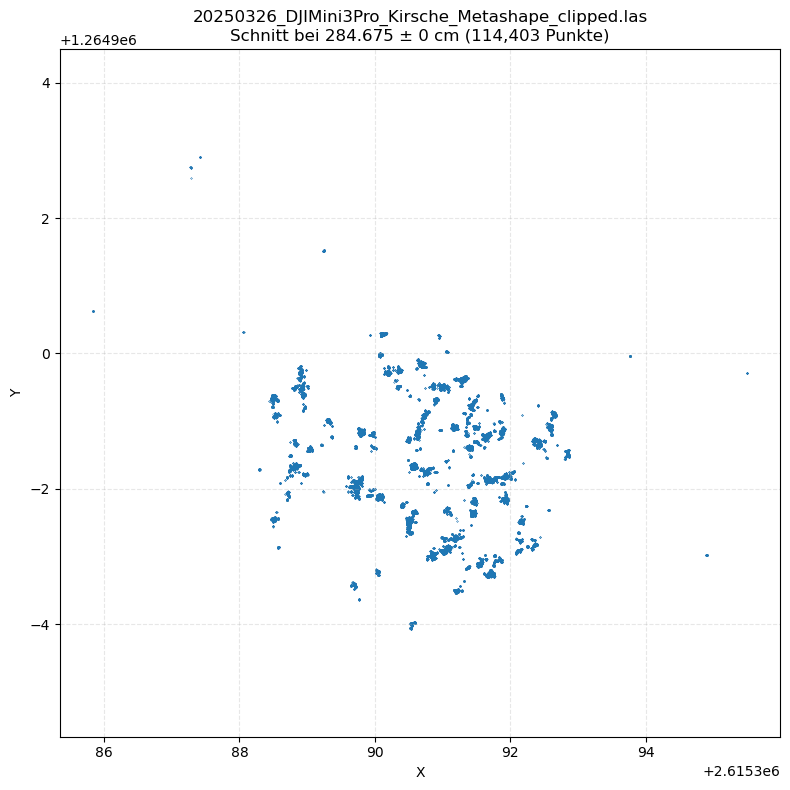

In [13]:
# === Parameter ===
filename = las_files[1]
tolerance = 0.005  # Schnittdicke ± in Metern

# === Punktwolke laden
path = os.path.join(pc_dir, filename)
las = laspy.read(path)
x, y, z = las.x, las.y, las.z

# === Maske für horizontalen Schnitt bei Tree_Null ± tolerance
mask = (z >= cut_height - tolerance) & (z <= cut_height + tolerance)

# === Schnelle 2D-Visualisierung in Schwarz
plt.figure(figsize=(8, 8))
plt.scatter(x[mask], y[mask], s=0.03, color="#1f77b4")
plt.title(f"{filename}\nSchnitt bei {cut_height:.3f} ± {tolerance*100:.0f} cm ({np.sum(mask):,} Punkte)")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis("equal")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

### 1.4 Small Multiples von horizontalen Schnitten

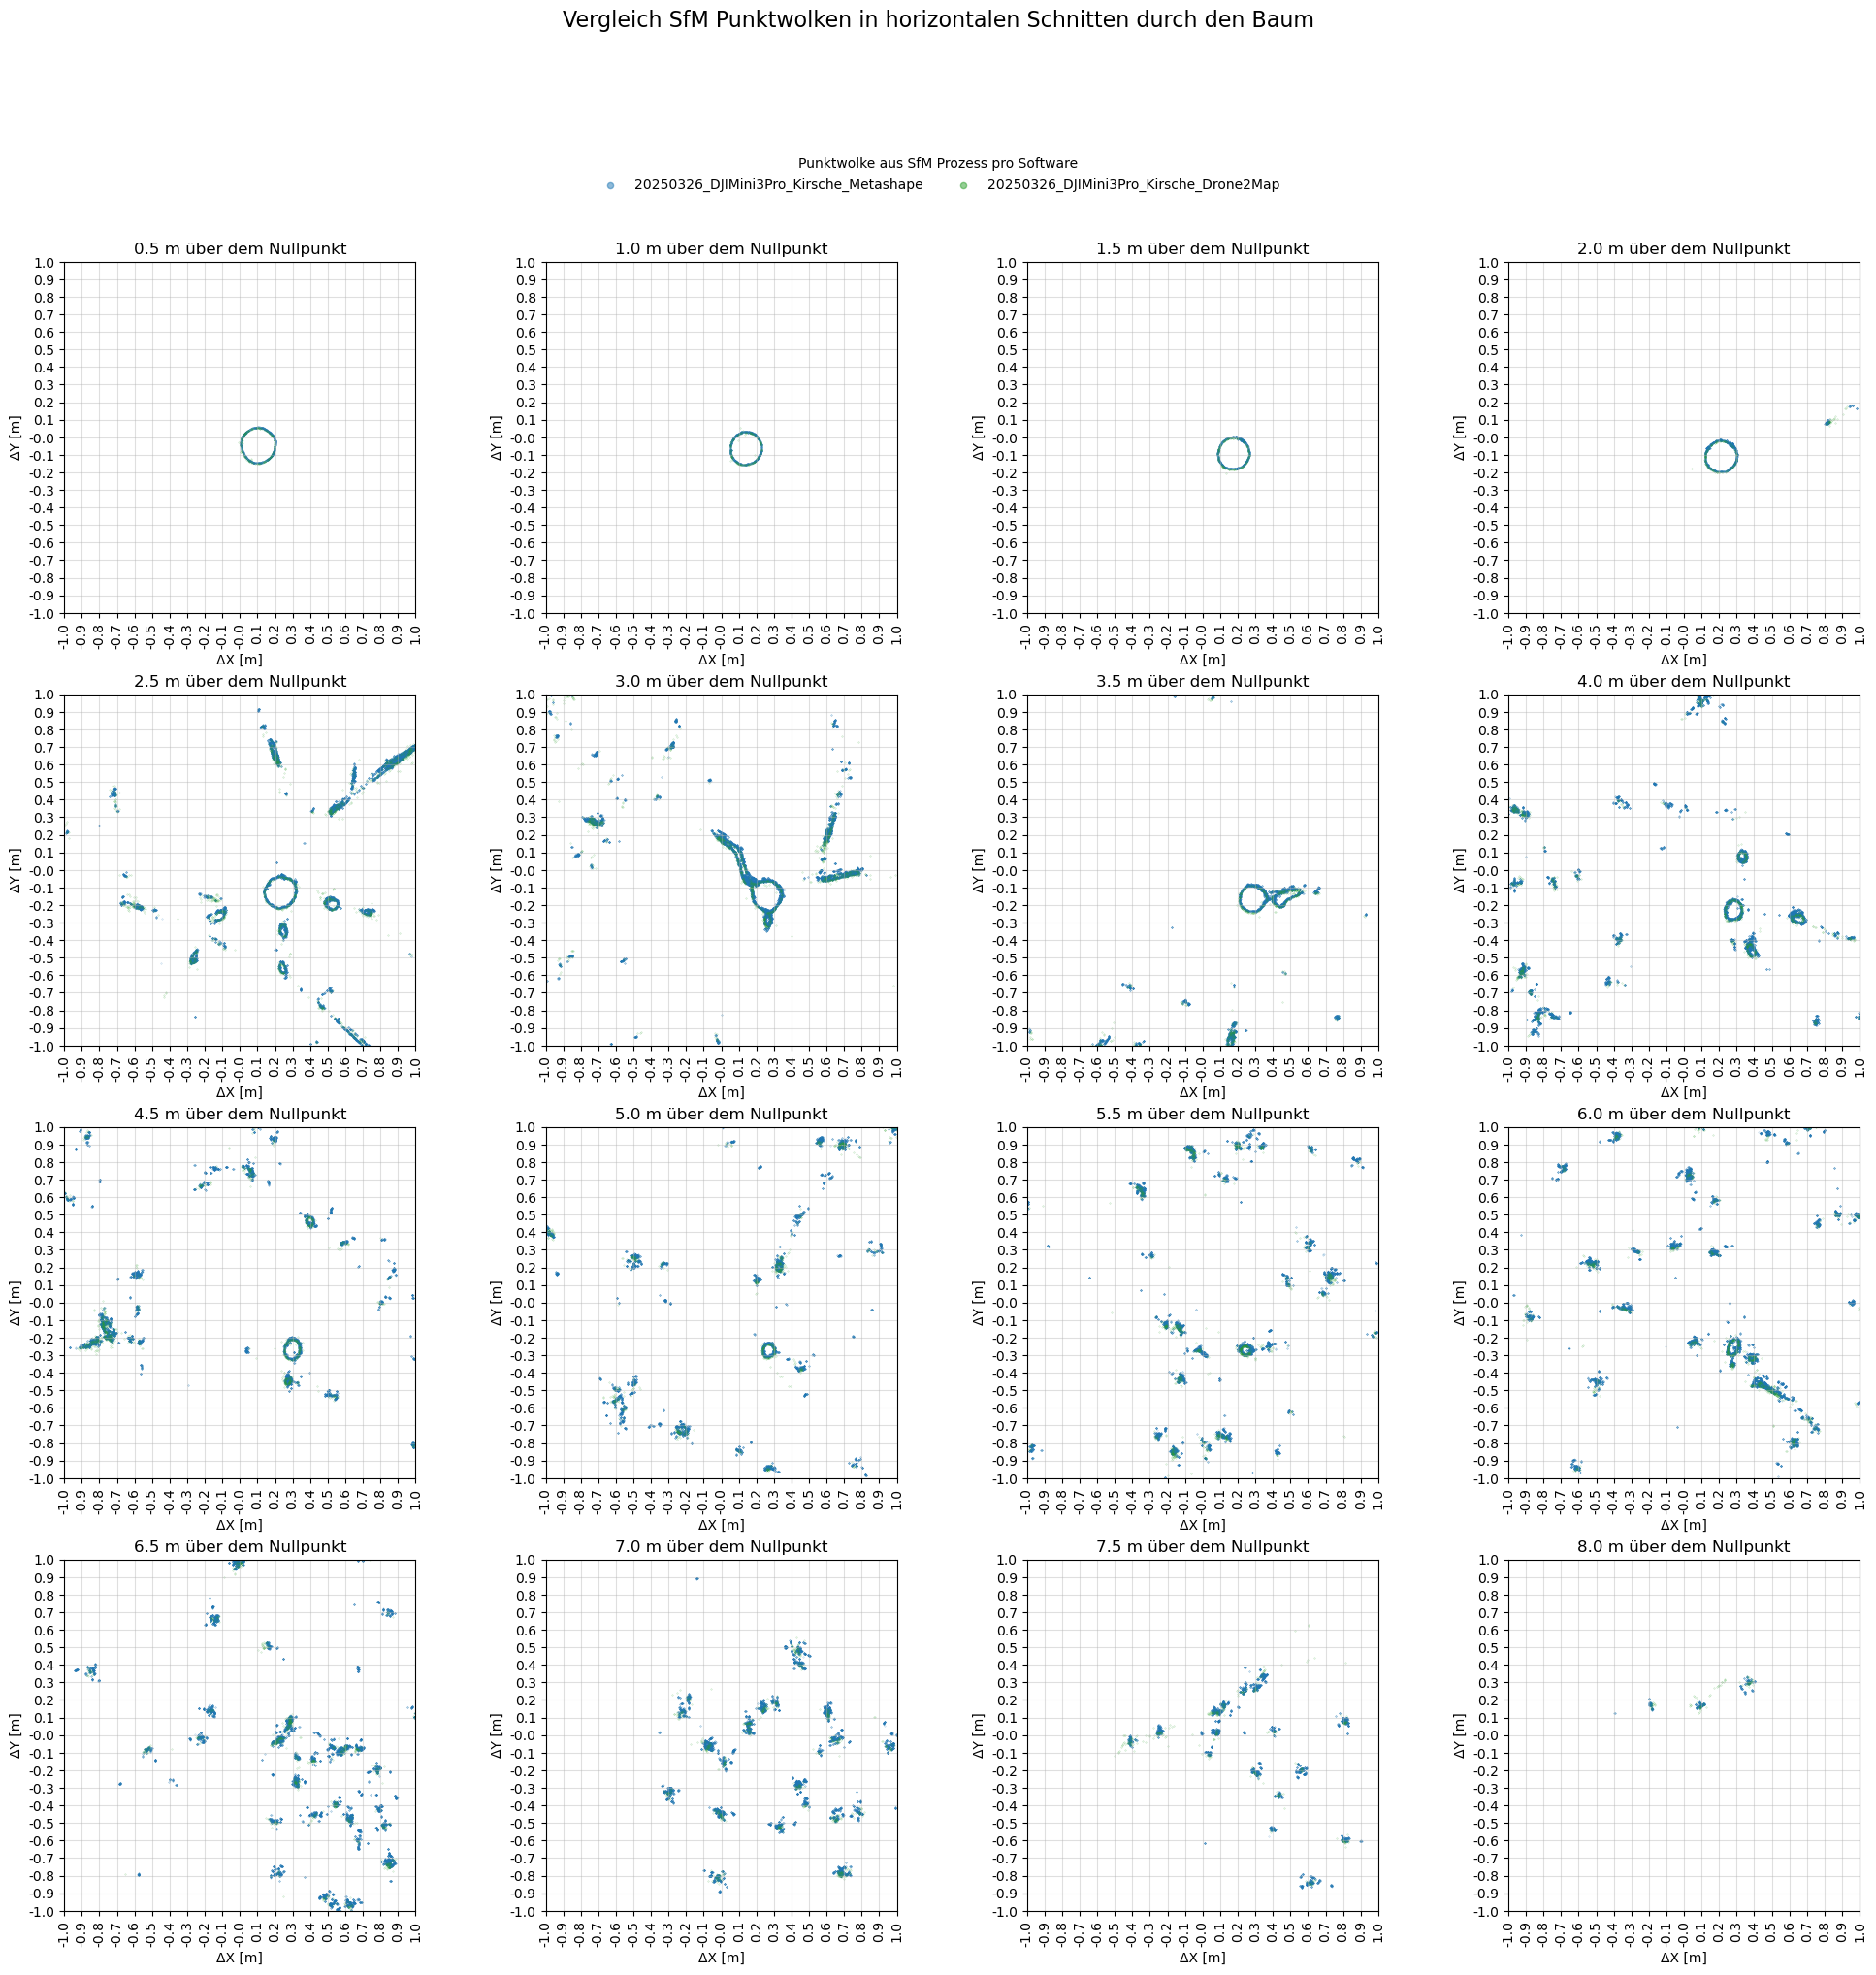

In [ ]:
# === Parameter ===
tolerance = 0.001
cut_levels = np.arange(0.5, 8.1, 0.5)  # Schnitthöhen ab tree_null
view_size = 1.0  # m in jede Richtung vom Mittelpunkt
colors = ["#1f77b4","#2ca02c"] 
alphas = [0.5, 0.5]

# === Punktwolken laden und relativ verschieben
pointclouds = []
for filename in sorted(las_files, reverse=True):
    path = os.path.join(pc_dir, filename)
    las = laspy.read(path)
    x = np.array(las.x) - center_x
    y = np.array(las.y) - center_y
    z = np.array(las.z)
    pointclouds.append({
        "filename": filename,
        "x": x,
        "y": y,
        "z": z
    })

# === Subplot-Layout
cols = 4
rows = int(np.ceil(len(cut_levels) / cols))
fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), squeeze=False)
fig.suptitle("Vergleich SfM Punktwolken in horizontalen Schnitten durch den Baum", fontsize=16, y=1.04)

# === Plots erzeugen
for idx, level in enumerate(cut_levels):
    cut_height = tree_null + level
    row, col = divmod(idx, cols)
    ax = axs[row][col]

    for i, pc in enumerate(pointclouds):
        mask = (pc["z"] >= cut_height - tolerance) & (pc["z"] <= cut_height + tolerance)
        ax.scatter(pc["x"][mask], pc["y"][mask], s=0.05,
                   color=colors[i % len(colors)],
                   alpha=alphas[i % len(alphas)],
                   label=pc["filename"].replace("_clipped.las", ""))

    ax.set_title(f"{level:.1f} m über dem Nullpunkt")
    ax.set_xlim(-view_size, view_size)
    ax.set_ylim(-view_size, view_size)
    ax.set_aspect('equal', 'box')
    ax.set_xlabel("ΔX [m]")
    ax.set_ylabel("ΔY [m]")

    ticks = np.arange(-view_size, view_size + 0.0001, 0.1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.tick_params(axis='x', rotation=90)

    formatter = FuncFormatter(lambda x, _: f"{x:.1f}")
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

    ax.grid(True, linestyle="-", alpha=0.4)

# === Leere Plots ausblenden
total_subplots = rows * cols
for idx in range(len(cut_levels), total_subplots):
    row, col = divmod(idx, cols)
    fig.delaxes(axs[row][col])

# === Legende
handles, labels = axs[0][0].get_legend_handles_labels()
fig.legend(handles, labels,
           title="Punktwolke aus SfM Prozess pro Software",
           loc="upper center", bbox_to_anchor=(0.5, 0.97),
           ncol=len(labels), frameon=False, markerscale=20)

# === Layout anpassen
plt.tight_layout()
plt.subplots_adjust(top=0.91, bottom=0.06)
plt.show()

### 1.5 interaktive horizontale Schnitte

Es werden interaktive Plots mit horizontalen Punktwolkenschnitten generiert, um einen Aufnahmesatz (Bilder) in den Programmen Metashape und Drone2Map zu vergleichen. Die Schnitthöhen ergeben sich ab einer definierten Nullhöhe pro Baum

#### 1.5.1 Aufnahme vom 11.03.2025 (Kirschbaum)

In [5]:
import laspy
import numpy as np
import os
import plotly.graph_objs as go
import re
from datetime import datetime

# === Parameter ===
tolerance = 0.001
cut_levels = np.arange(0.5, 8.1, 0.5)
view_size = 1.0
colors = {"Drone2Map": "#2ca02c", "Metashape": "#1f77b4"}
alphas = {"Drone2Map": 1.0, "Metashape": 0.8}

# === Referenzpunkt
tree_null = 279.675
tree_coord = (2615390.524, 1264898.409)
center_x, center_y = tree_coord
pc_dir = r"C:\_Data\BTh11\BTh11_Trieblaengenwachstum\05_Software_Comparison\50_BaseData\PointCloud\20250311"
las_files = sorted([f for f in os.listdir(pc_dir) if f.endswith(".las")])

# === Softwarenamen und Datum aus Dateinamen
softwares = []
aufnahme_datum = None
for fname in las_files:
    match = re.match(r"(\d{8})_.*_(Drone2Map|Metashape)", fname)
    if match:
        datum_str, sw = match.groups()
        if sw not in softwares:
            softwares.append(sw)
        if aufnahme_datum is None:
            aufnahme_datum = datetime.strptime(datum_str, "%Y%m%d").strftime("%d.%m.%Y")

# === Punktwolken einlesen
pointclouds = []
for fname in las_files:
    path = os.path.join(pc_dir, fname)
    las = laspy.read(path)
    x = np.array(las.x) - center_x
    y = np.array(las.y) - center_y
    z = np.array(las.z)
    software = "Drone2Map" if "Drone2Map" in fname else "Metashape"
    pointclouds.append({
        "filename": fname,
        "x": x,
        "y": y,
        "z": z,
        "label": software
    })

# === Plotly-Figur vorbereiten
fig = go.Figure()
trace_matrix = []  # Speichert die Trace-Indizes pro Schnitt

# === Traces hinzufügen
# === Traces hinzufügen
trace_index = 0
for j, level in enumerate(cut_levels):
    cut_height = tree_null + level
    trace_group = []

    for pc in sorted(pointclouds, key=lambda p: p["label"] == "Drone2Map"):
        sw = pc["label"]
        mask = (pc["z"] >= cut_height - tolerance) & (pc["z"] <= cut_height + tolerance)

        fig.add_trace(go.Scattergl(
            x=pc["x"][mask],
            y=pc["y"][mask],
            mode='markers',
            marker=dict(size=3, color=colors[sw], opacity=alphas[sw]),
            name=sw,
            legendgroup=f"{sw}_{j}",
            showlegend=True,
            visible=(j == 0)
        ))

        trace_group.append(trace_index)
        trace_index += 1

    trace_matrix.append(trace_group)

# === Dropdown-Menü
buttons = []
for j, level in enumerate(cut_levels):
    vis = [False] * trace_index
    for idx in trace_matrix[j]:
        vis[idx] = True

    label = f"{level:.1f} m über dem Nullpunkt"
    buttons.append(dict(
        label=label,
        method="update",
        args=[{"visible": vis}]
    ))


# === Layout
fig.update_layout(
    updatemenus=[dict(
        type="dropdown",
        active=0,
        buttons=buttons,
        x=0.5,
        xanchor="center",
        y=1.07,
        yanchor="top"
    )],
    xaxis=dict(title="ΔE [m]", range=[-view_size, view_size], dtick=0.1,
               showgrid=True, gridcolor="lightgray", zeroline=False),
    yaxis=dict(title="ΔN [m]", range=[-view_size, view_size], dtick=0.1,
               showgrid=True, gridcolor="lightgray", zeroline=False,
               scaleanchor="x"),
    legend=dict(
        title="Punktwolke aus SfM Prozess pro Software",
        orientation="h",
        yanchor="bottom",
        y=-0.25,
        x=0.5,
        xanchor="center",
        font=dict(size=10)
    ),
    plot_bgcolor="white",
    width=800,
    height=880,
    margin=dict(t=160),
    annotations=[
        dict(
            text=f"Punktwolken aus photogrammetrischen Aufnahmen vom {aufnahme_datum}",
            xref="paper", yref="paper",
            x=0.5, y=1.17,
            xanchor="center", yanchor="top",
            showarrow=False,
            font=dict(size=16)
        ),
        dict(
            text=f"Schnitte in 0.5 m-Schritten (± {tolerance*1000:.0f} mm Toleranz) relativ zum Nullpunkt bei {tree_null:.3f} m.",
            xref="paper", yref="paper",
            x=0.5, y=1.12,
            xanchor="center", yanchor="top",
            showarrow=False,
            font=dict(size=12, color="gray")
        )
    ]
)

fig.show()

#### 1.5.2 Aufnahmen vom 26.03.2025 (Kirschbaum)

In [3]:
import laspy
import numpy as np
import os
import plotly.graph_objs as go
import re
from datetime import datetime

# === Parameter ===
tolerance = 0.001
cut_levels = np.arange(0.5, 8.1, 0.5)
view_size = 1.0
colors = {"Drone2Map": "#2ca02c", "Metashape": "#1f77b4"}
alphas = {"Drone2Map": 1.0, "Metashape": 0.8}

# === Referenzpunkt
tree_null = 279.675
tree_coord = (2615390.524, 1264898.409)
center_x, center_y = tree_coord
pc_dir = r"C:\_Data\BTh11\BTh11_Trieblaengenwachstum\05_Software_Comparison\50_BaseData\PointCloud\20250326"
las_files = sorted([f for f in os.listdir(pc_dir) if f.endswith(".las")])

# === Softwarenamen und Datum aus Dateinamen
softwares = []
aufnahme_datum = None
for fname in las_files:
    match = re.match(r"(\d{8})_.*_(Drone2Map|Metashape)", fname)
    if match:
        datum_str, sw = match.groups()
        if sw not in softwares:
            softwares.append(sw)
        if aufnahme_datum is None:
            aufnahme_datum = datetime.strptime(datum_str, "%Y%m%d").strftime("%d.%m.%Y")

# === Punktwolken einlesen
pointclouds = []
for fname in las_files:
    path = os.path.join(pc_dir, fname)
    las = laspy.read(path)
    x = np.array(las.x) - center_x
    y = np.array(las.y) - center_y
    z = np.array(las.z)
    software = "Drone2Map" if "Drone2Map" in fname else "Metashape"
    pointclouds.append({
        "filename": fname,
        "x": x,
        "y": y,
        "z": z,
        "label": software
    })

# === Plotly-Figur vorbereiten
fig = go.Figure()
trace_matrix = []  # Speichert die Trace-Indizes pro Schnitt

# === Traces hinzufügen
trace_index = 0
for j, level in enumerate(cut_levels):
    cut_height = tree_null + level
    trace_group = []

    for pc in sorted(pointclouds, key=lambda p: p["label"] == "Drone2Map"):
        sw = pc["label"]
        mask = (pc["z"] >= cut_height - tolerance) & (pc["z"] <= cut_height + tolerance)

        fig.add_trace(go.Scattergl(
            x=pc["x"][mask],
            y=pc["y"][mask],
            mode='markers',
            marker=dict(size=3, color=colors[sw], opacity=alphas[sw]),
            name=sw,
            legendgroup=f"{sw}_{j}",
            showlegend=True,
            visible=(j == 0)
        ))

        trace_group.append(trace_index)
        trace_index += 1

    trace_matrix.append(trace_group)

# === Dropdown-Menü
buttons = []
for j, level in enumerate(cut_levels):
    vis = [False] * trace_index
    for idx in trace_matrix[j]:
        vis[idx] = True

    label = f"{level:.1f} m über dem Nullpunkt"
    buttons.append(dict(
        label=label,
        method="update",
        args=[{"visible": vis}]
    ))


# === Layout
fig.update_layout(
    updatemenus=[dict(
        type="dropdown",
        active=0,
        buttons=buttons,
        x=0.5,
        xanchor="center",
        y=1.07,
        yanchor="top"
    )],
    xaxis=dict(title="ΔE [m]", range=[-view_size, view_size], dtick=0.1,
               showgrid=True, gridcolor="lightgray", zeroline=False),
    yaxis=dict(title="ΔN [m]", range=[-view_size, view_size], dtick=0.1,
               showgrid=True, gridcolor="lightgray", zeroline=False,
               scaleanchor="x"),
    legend=dict(
        title="Punktwolke aus SfM Prozess pro Software",
        orientation="h",
        yanchor="bottom",
        y=-0.25,
        x=0.5,
        xanchor="center",
        font=dict(size=10)
    ),
    plot_bgcolor="white",
    width=800,
    height=880,
    margin=dict(t=160),  # <-- mehr Platz oben
    annotations=[
        dict(
            text=f"Punktwolken aus photogrammetrischen Aufnahmen vom {aufnahme_datum}",
            xref="paper", yref="paper",
            x=0.5, y=1.17,
            xanchor="center", yanchor="top",
            showarrow=False,
            font=dict(size=16)
        ),
        dict(
            text=f"Schnitte in 0.5 m-Schritten (± {tolerance*1000:.0f} mm Toleranz) relativ zum Nullpunkt bei {tree_null:.3f} m.",
            xref="paper", yref="paper",
            x=0.5, y=1.12,
            xanchor="center", yanchor="top",
            showarrow=False,
            font=dict(size=12, color="gray")
        )
    ]
)

fig.show()

### 1.6 interaktive vertikale Schnitte

#### 1.6.1 Aufnahmen vom 26.11.2025

In [ ]:
import laspy
import numpy as np
import os
import plotly.graph_objs as go
import re
from datetime import datetime

# === Parameter ===
tolerance_n = 0.003
tolerance_e = 0.003
cut_levels = np.arange(-1.0, 1.01, 0.1)
view_n = 1.0
view_e = 1.0
view_z = 10

colors = {"Drone2Map": "#2ca02c", "Metashape": "#1f77b4"}
alphas = {"Drone2Map": 1.0, "Metashape": 1.0}

# === Referenzpunkt
tree_null = 279.675
tree_coord = (2615390.3, 1264898.6)
center_x, center_y = tree_coord

# === Punktwolkenverzeichnis
pc_dir = r"C:\_Data\BTh11\BTh11_Trieblaengenwachstum\05_Software_Comparison\50_BaseData\PointCloud\20250326"
las_files = sorted([f for f in os.listdir(pc_dir) if f.endswith(".las")])

# === Softwarenamen + Datum
aufnahme_datum = None
for fname in las_files:
    match = re.match(r"(\d{8})_.*_(Drone2Map|Metashape)", fname)
    if match:
        datum_str = match.groups()[0]
        aufnahme_datum = datetime.strptime(datum_str, "%Y%m%d").strftime("%d.%m.%Y")
        break

# === Punktwolken einlesen
pointclouds = []
for fname in las_files:
    path = os.path.join(pc_dir, fname)
    las = laspy.read(path)
    x = np.array(las.x) - center_x
    y = np.array(las.y) - center_y
    z = np.array(las.z)
    software = "Drone2Map" if "Drone2Map" in fname else "Metashape"
    pointclouds.append({
        "filename": fname,
        "x": x,
        "y": y,
        "z": z,
        "label": software
    })

# === Hilfsfunktion zum Erstellen der Traces ===
def create_vertical_figure(cut_axis, tolerance, view_range, axis_title, cut_label):
    fig = go.Figure()
    trace_matrix = []
    trace_index = 0

    for j, offset in enumerate(cut_levels):
        group = []
        for i, pc in enumerate(pointclouds):
            sw = pc["label"]
            mask = np.abs(pc[cut_axis] - offset) <= tolerance

            fig.add_trace(go.Scattergl(
                x=pc["y" if cut_axis == "x" else "x"][mask],
                y=pc["z"][mask],
                mode="markers",
                marker=dict(size=2, color=colors[sw], opacity=alphas[sw]),
                name=sw,
                legendgroup=f"{sw}_{j}",
                showlegend=True,
                visible=(j == 0)
            ))
            group.append(trace_index)
            trace_index += 1
        trace_matrix.append(group)

    buttons = []
    for j, offset in enumerate(cut_levels):
        vis = [False] * trace_index
        for idx in trace_matrix[j]:
            vis[idx] = True
        buttons.append(dict(label=f"{offset:.2f} m", method="update", args=[{"visible": vis}]))

    fig.update_layout(
        title=f"Vertikalschnitt {cut_label} – Höhe",
        updatemenus=[dict(
            type="dropdown",
            active=0,
            buttons=buttons,
            x=0.5,
            xanchor="center",
            y=1.05,
            yanchor="top"
        )],
        xaxis=dict(title=axis_title, range=[-view_range, view_range], dtick=0.5, scaleanchor="y"),
        yaxis=dict(title="Höhe [m]", range=[tree_null, tree_null + view_z], dtick=1),
        legend=dict(
            title="Software",
            orientation="h",
            yanchor="bottom",
            y=-0.25,
            x=0.5,
            xanchor="center",
            font=dict(size=10)
        ),
        plot_bgcolor="white",
        width=600,
        height=850,
        margin=dict(t=180),
        annotations=[
            dict(
                text=f"Punktwolken vom {aufnahme_datum} ({'ΔE' if cut_axis == 'x' else 'ΔN'} ≈ {0:.3f} m ± {tolerance:.3f} m)",
                xref="paper", yref="paper",
                x=0.5, y=1.12,
                xanchor="center", yanchor="top",
                showarrow=False,
                font=dict(size=12)
            )
        ]
    )
    return fig

# === Figuren erstellen
fig_ns = create_vertical_figure("x", tolerance_n, view_n, "ΔN [m]", "Nord-Süd")
fig_ew = create_vertical_figure("y", tolerance_e, view_e, "ΔE [m]", "Ost-West")

# === Anzeigen
fig_ns.show()
fig_ew.show()
